Importar bibliotecas

In [54]:
import os
import yaml
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from folium.plugins import MarkerCluster
from IPython.display import IFrame
from xgboost import XGBClassifier



Carregamento do .db

In [16]:
def load_config(CONFIG_PATH):
    with open(CONFIG_PATH, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

BASE_DIR = Path().resolve().parent.parent
CONFIG_PATH = BASE_DIR / "config" / "config.yaml"

config = load_config(CONFIG_PATH)

DB_PATH = os.path.join(BASE_DIR, config["database"]["save_path_processed_databases"],"acidentes_infosiga.db")   # caminho definido nas etapas anteriores
print(DB_PATH)
conn = sqlite3.connect(DB_PATH)

# já usamos a tabela final, pós-transformação (ex: "acidentes_final")
df = pd.read_sql("SELECT * FROM sinistros", conn)
conn.close()


print("Shape do dataset final:", df.shape)
df.head()

C:\Code\Codes\AcidenteInSight\data\processed\databases\acidentes_infosiga.db
Shape do dataset final: (835076, 43)


,id_sinistro,tipo_registro,data_sinistro,ano_sinistro,mes_sinistro,dia_sinistro,ano_mes_sinistro,hora_sinistro,logradouro,numero_logradouro,...,tp_sinistro_colisao_traseira,tp_sinistro_colisao_lateral,tp_sinistro_colisao_transversal,tp_sinistro_colisao_outros,tp_sinistro_choque,tp_sinistro_capotamento,tp_sinistro_engavetamento,tp_sinistro_tombamento,tp_sinistro_outros,tp_sinistro_nao_disponivel
0,2501575,SINISTRO FATAL,21/12/2014,2014,12,21,2014/12,20:00,RUA MANOEL MACHADO PEREIRA,905.0,...,None,None,None,None,None,None,None,None,None,None
1,2456933,SINISTRO FATAL,23/12/2014,2014,12,23,2014/12,None,AVENIDA VINTE E TRES,1000.0,...,None,None,None,None,None,None,None,None,None,S
2,2463759,SINISTRO FATAL,26/12/2014,2014,12,26,2014/12,06:52,AVENIDA REBOUCAS,300.0,...,None,None,None,None,None,None,None,None,None,None
3,2487781,SINISTRO FATAL,28/12/2014,2014,12,28,2014/12,14:30,ESTRADA EGÍLIO VITORELLO,589.0,...,None,None,None,None,None,None,None,None,None,None
4,2489730,SINISTRO FATAL,28/12/2014,2014,12,28,2014/12,None,AVENIDA SAO PAULO,NaN,...,None,None,None,None,None,None,None,None,None,S


Preparação para modelagem

C:\Users\diego\AppData\Local\Temp\ipykernel_4728\1174092677.py:26: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  X['data_sinistro'] = pd.to_datetime(X['data_sinistro'], errors='coerce')


    ano_sinistro       tipo_registro  proporcao
0           2014      SINISTRO FATAL   1.000000
1           2015      SINISTRO FATAL   1.000000
2           2016      SINISTRO FATAL   1.000000
3           2017      SINISTRO FATAL   1.000000
4           2018      SINISTRO FATAL   1.000000
5           2019  SINISTRO NAO FATAL   0.960368
6           2019      SINISTRO FATAL   0.039632
7           2020  SINISTRO NAO FATAL   0.960474
8           2020      SINISTRO FATAL   0.039526
9           2021  SINISTRO NAO FATAL   0.963511
10          2021      SINISTRO FATAL   0.036489
11          2022  SINISTRO NAO FATAL   0.960977
12          2022      SINISTRO FATAL   0.039023
13          2023  SINISTRO NAO FATAL   0.963279
14          2023      SINISTRO FATAL   0.036721
15          2024  SINISTRO NAO FATAL   0.957322
16          2024      SINISTRO FATAL   0.042678
17          2025  SINISTRO NAO FATAL   0.949072
18          2025      SINISTRO FATAL   0.050928


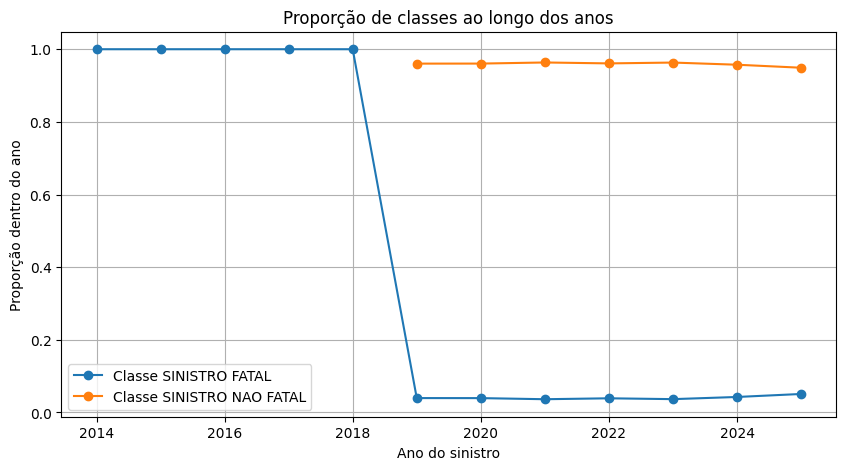

C:\Users\diego\AppData\Local\Temp\ipykernel_4728\1174092677.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'SINISTRO NAO FATAL': 0, 'SINISTRO FATAL': 1})


Shape X: (813858, 31)
Shape y: (813858,)
Colunas X: Index(['ano_sinistro', 'mes_sinistro', 'dia_sinistro', 'hora_sinistro',
       'tipo_via', 'latitude', 'longitude', 'municipio',
       'regiao_administrativa', 'tp_veiculo_bicicleta', 'tp_veiculo_caminhao',
       'tp_veiculo_motocicleta', 'tp_veiculo_onibus', 'tp_veiculo_outros',
       'tp_veiculo_automovel', 'administracao', 'conservacao', 'jurisdicao',
       'tipo_acidente_primario', 'tp_sinistro_atropelamento',
       'tp_sinistro_colisao_frontal', 'tp_sinistro_colisao_traseira',
       'tp_sinistro_colisao_lateral', 'tp_sinistro_colisao_transversal',
       'tp_sinistro_colisao_outros', 'tp_sinistro_choque',
       'tp_sinistro_capotamento', 'tp_sinistro_engavetamento',
       'tp_sinistro_tombamento', 'tp_sinistro_outros', 'dia_semana'],
      dtype='object')


In [64]:
# ===============================
# Pré-processamento do dataset
# ===============================

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Drop de colunas irrelevantes ---
cols_to_drop = [
    "id_sinistro",
    "tp_veiculo_nao_disponivel",
    "gravidade_nao_disponivel",
    "tp_sinistro_nao_disponivel",
    "logradouro",
    "numero_logradouro",
    "ano_mes_sinistro"
]
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop)

# --- Separando features e target ---
y = df["tipo_registro"]  # ajuste conforme o alvo desejado
X = df.drop(columns=["tipo_registro"])

# --- Converter datas e horas ---
X['data_sinistro'] = pd.to_datetime(X['data_sinistro'], errors='coerce')
X['hora_sinistro'] = pd.to_datetime(X['hora_sinistro'], format='%H:%M', errors='coerce').dt.hour + \
                     pd.to_datetime(X['hora_sinistro'], format='%H:%M', errors='coerce').dt.minute / 60
X['hora_sinistro'] = X['hora_sinistro'].fillna(X['hora_sinistro'].median())

# --- Converter coordenadas para float ---
for col in ['latitude', 'longitude']:
    if col in X.columns:
        X[col] = X[col].str.replace(',', '.').astype(float)
        X[col] = X[col].fillna(X[col].mean())
prop_por_ano = (
    df.groupby("ano_sinistro")["tipo_registro"]
    .value_counts(normalize=True)
    .rename("proporcao")
    .reset_index()
)

print(prop_por_ano)

# 2. Visualizar em gráfico
plt.figure(figsize=(10,5))
for classe in prop_por_ano["tipo_registro"].unique():
    subset = prop_por_ano[prop_por_ano["tipo_registro"] == classe]
    plt.plot(subset["ano_sinistro"], subset["proporcao"], marker="o", label=f"Classe {classe}")

plt.title("Proporção de classes ao longo dos anos")
plt.xlabel("Ano do sinistro")
plt.ylabel("Proporção dentro do ano")
plt.legend()
plt.grid(True)
plt.show()
# --- Criar features de data ---
X['mes_sinistro'] = X['data_sinistro'].dt.month
X['dia_sinistro'] = X['data_sinistro'].dt.day
X['dia_semana'] = X['data_sinistro'].dt.dayofweek
X = X.drop(columns=['data_sinistro'])

anos_remover = [2014, 2015, 2016, 2017, 2018]
mask = ~X['ano_sinistro'].isin(anos_remover)

X = X[mask]
y = y[mask]
y = y.replace({'SINISTRO NAO FATAL': 0, 'SINISTRO FATAL': 1})
# --- Remover colunas que causam vazamento ---
cols_to_remove_due_to_leakage = [
    "gravidade_leve", "gravidade_grave", "gravidade_ileso", "gravidade_fatal",
]
X = X.drop(columns=[col for col in cols_to_remove_due_to_leakage if col in X.columns])

# --- Label Encoding para colunas categóricas ---
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- Conferindo shapes finais ---
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Colunas X:", X.columns)


Test/Train Split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (651086, 31) Teste: (162772, 31)


Modelagem

In [76]:
modelo = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=10,  # valor moderado para não exagerar nos 1s
    use_label_encoder=False,
    eval_metric='logloss'
)


modelo.fit(X_train, y_train)


y_proba = modelo.predict_proba(X_test)[:, 1]

threshold = 0.75
y_pred_adjusted = (y_proba >= threshold).astype(int)


C:\Users\diego\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:33:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliação

In [77]:
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_adjusted))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_adjusted))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    156315
           1       0.66      0.46      0.54      6457

    accuracy                           0.97    162772
   macro avg       0.82      0.73      0.76    162772
weighted avg       0.97      0.97      0.97    162772

Matriz de Confusão:
 [[154772   1543]
 [  3485   2972]]


Importância das variáveis

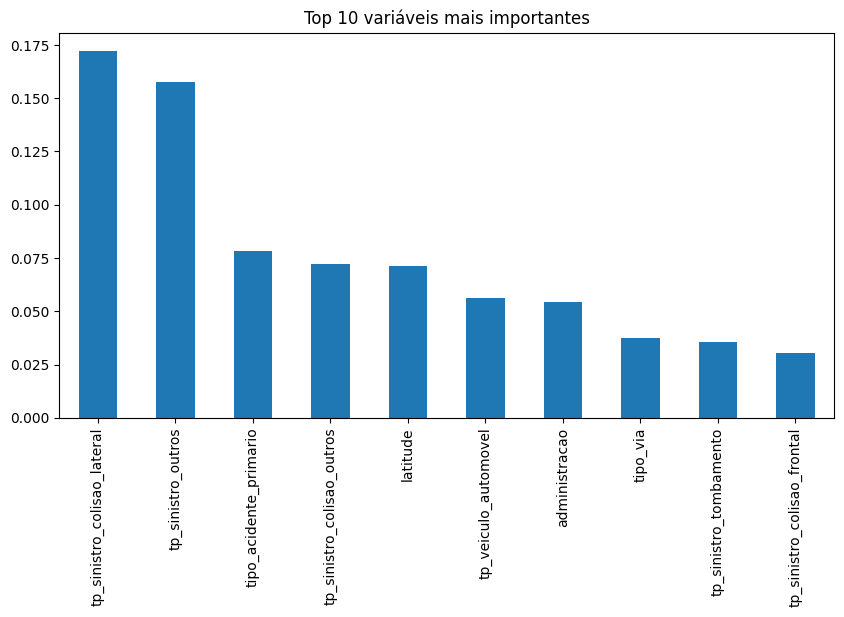

In [78]:
importances = pd.Series(modelo.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 variáveis mais importantes")
plt.show()

Heatmap

In [ ]:

import folium
from folium.plugins import HeatMap
import pandas as pd

# --- Preparar dataset ---
df_plot = X.copy()
df_plot['tipo_registro'] = y

# Converter latitude e longitude para float
df_plot['latitude'] = pd.to_numeric(df_plot['latitude'].astype(str).str.replace(',', '.'), errors='coerce')
df_plot['longitude'] = pd.to_numeric(df_plot['longitude'].astype(str).str.replace(',', '.'), errors='coerce')

# Remover valores inválidos
df_plot = df_plot[(df_plot['latitude'].between(-90, 90)) & 
                  (df_plot['longitude'].between(-180, 180))]

# --- Criar mapa centrado na média da latitude e longitude ---
map_center = [df_plot['latitude'].mean(), df_plot['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# --- HeatMap de acidentes FATAIS ---
fatal = df_plot[df_plot['tipo_registro'] == 1]
fatal_data = fatal[['latitude', 'longitude']].values.tolist()
HeatMap(fatal_data, radius=8, blur=10, gradient={0.4:'orange',0.65:'red',1:'darkred'}, name='FATAIS').add_to(m)

# --- HeatMap de acidentes NÃO FATAIS ---
nao_fatal = df_plot[df_plot['tipo_registro'] == 0]
nao_fatal_data = nao_fatal[['latitude', 'longitude']].values.tolist()
HeatMap(nao_fatal_data, radius=6, blur=8, gradient={0.4:'lightblue',0.65:'blue',1:'darkblue'}, name='NÃO FATAIS').add_to(m)

# --- Adicionar camada de controle ---
folium.LayerControl().add_to(m)

# --- Exibir mapa ---
m.save("mapa_acidentes.html")
IFrame("mapa_acidentes.html", width=800, height=600)


Heatmap de correlação de variáveis

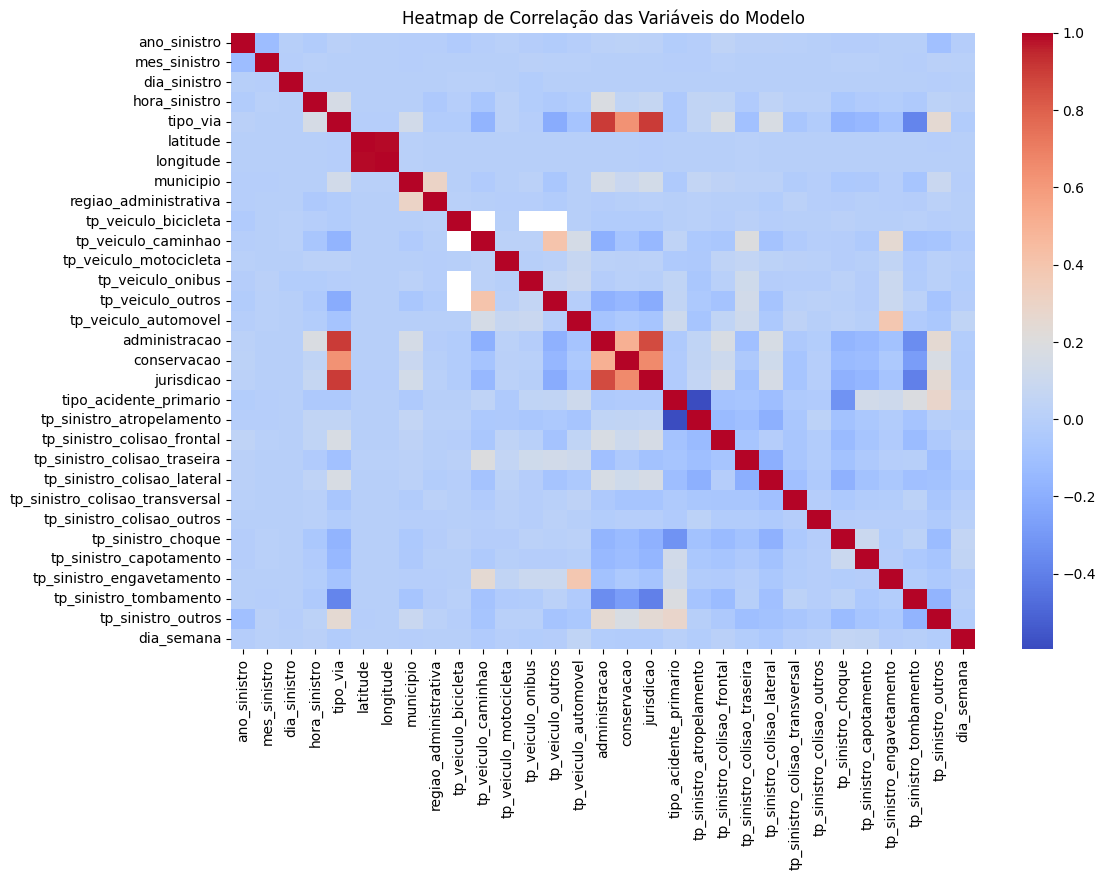

In [79]:
# Calcular correlação apenas entre variáveis explicativas
corr = X.corr()

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title("Heatmap de Correlação das Variáveis do Modelo")
plt.show()

Heatmap de corelação variáveis - target

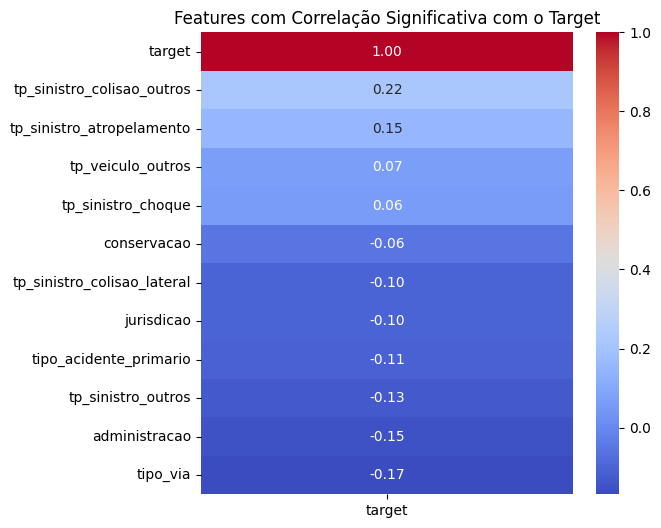

In [80]:
# Criar DataFrame temporário juntando X e y
df_temp = X.copy()
df_temp['target'] = y

# Calcular correlação de todas as features com o target
corr = df_temp.corr()

# Selecionar apenas features com correlação significativa
corr_target = corr['target']
corr_relevante = corr_target[(corr_target.abs() > 0.05)].sort_values(ascending=False)

# Plotar heatmap
plt.figure(figsize=(6, len(corr_relevante)*0.5))
sns.heatmap(corr_relevante.to_frame(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Features com Correlação Significativa com o Target")
plt.show()